In [1]:
import functions as fun
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers



df = pd.read_csv("./housing_full.csv")

In [2]:
def import_housing_data(url):
  import pandas as pd
  df = pd.read_csv(url)
  df.drop(columns=["Id"], inplace=True)
  df.dropna(axis=1, inplace=True)

  for col in df:
    if col[0].isdigit():
      nums = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
      df.rename(columns={col:nums[int(col[0])]}, inplace=True)

  return df

In [3]:
df = import_housing_data("./housing_full.csv")

In [4]:
for col in df: 
  if not pd.api.types.is_any_real_numeric_dtype(df[col]):
    df = df.join(pd.get_dummies(df[col], prefix=col, drop_first=False).astype(int))
scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

df = df.select_dtypes(int)

In [5]:
y = price_scaler.fit_transform(df[['SalePrice']])

X = df.drop("SalePrice", axis=1)
X = scaler.fit_transform(X)

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.layers import Dropout

input_layer = keras.Input(shape=(X_train.shape[1],))

x = layers.Dense(128, kernel_initializer='he_normal')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = Dropout(0.4)(x)  

x = layers.Dense(64, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = Dropout(0.4)(x)  

x = layers.Dense(32, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = Dropout(0.4)(x) 
# Output layer
output_layer = layers.Dense(1, activation='linear')(x)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)


In [7]:
model.compile(optimizer=keras.optimizers.legacy.Adam(0.0005), loss='mean_squared_error',  metrics=['mean_absolute_error', keras.metrics.RootMeanSquaredError() ])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=50, 
                               restore_best_weights=True)

In [9]:
history = model.fit(X_train, y_train, epochs=350, batch_size=32, validation_data=(X_dev, y_dev),  callbacks=[early_stopping])

Epoch 1/350
37/37 [==============================] - 1s 4ms/step - loss: 1.2294 - mean_absolute_error: 0.8601 - root_mean_squared_error: 1.1088 - val_loss: 0.0368 - val_mean_absolute_error: 0.1488 - val_root_mean_squared_error: 0.1917
Epoch 2/350
37/37 [==============================] - 0s 2ms/step - loss: 1.0585 - mean_absolute_error: 0.7844 - root_mean_squared_error: 1.0288 - val_loss: 0.0398 - val_mean_absolute_error: 0.1520 - val_root_mean_squared_error: 0.1996
Epoch 3/350
37/37 [==============================] - 0s 2ms/step - loss: 0.8348 - mean_absolute_error: 0.7002 - root_mean_squared_error: 0.9137 - val_loss: 0.0417 - val_mean_absolute_error: 0.1544 - val_root_mean_squared_error: 0.2043
Epoch 4/350
37/37 [==============================] - 0s 2ms/step - loss: 0.6763 - mean_absolute_error: 0.6267 - root_mean_squared_error: 0.8224 - val_loss: 0.0400 - val_mean_absolute_error: 0.1537 - val_root_mean_squared_error: 0.2000
Epoch 5/350
37/37 [==============================] - 0s 1ms/

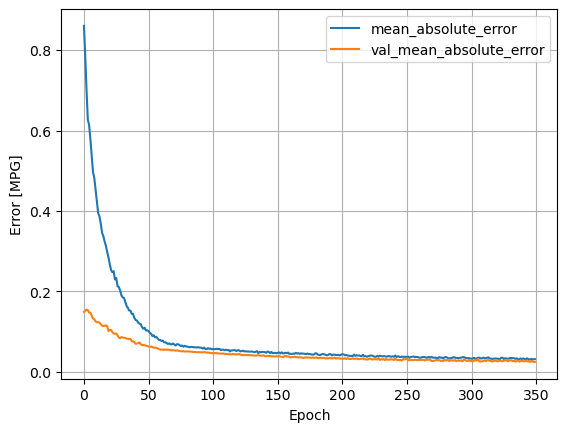

In [10]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
def plot_mae(history):
  plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)  
#plot_loss(history)
plot_mae(history)

In [11]:
loss, mae, maep = model.evaluate(X_dev, y_dev)
train_loss, train_mae, train_maep = model.evaluate(X_train, y_train)

print(f"Test Loss: {loss}")
scaled_mae = mae
scaled_train_mae = train_mae
original_mae = scaled_mae * (price_scaler.data_max_ - price_scaler.data_min_)
original_train_mae = scaled_train_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original MAE: {mae}")
print(f"Original train MAE: {train_mae}")
print(f"Original MAPE: {maep}")
print(f"Original train MAPE: {train_maep}")

print(f"Scaled MAE: {original_mae[0]}")
print(f"Scaled train MAE: {original_train_mae[0]}")


37/37 [==============================] - 0s 506us/step - loss: 5.7618e-04 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0240
Test Loss: 0.0019539908971637487
Original MAE: 0.024722155183553696
Original train MAE: 0.01520939078181982
Original MAPE: 0.044203970581293106
Original train MAPE: 0.024003690108656883
Scaled MAE: 17802.423947677016
Scaled train MAE: 10952.282301988453


In [12]:
from sklearn.metrics import r2_score

y_pred_train = model.predict(X_train)
y_pred_dev = model.predict(X_dev)
r2_train = r2_score(y_train, y_pred_train)
r2_dev = r2_score(y_dev, y_pred_dev)
print(f"R2 - Train Score: {r2_train}")
print(f"R2 - Dev Score: {r2_dev}")


10/10 [==============================] - 0s 541us/step
R2 - Train Score: 0.9499085137467733
R2 - Dev Score: 0.8679025564671989


In [13]:
n_train = y_train.shape[0]  
p_train = y_train.shape[1] 

n_dev = y_dev.shape[0]  
p_dev = y_dev.shape[1] 

adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
print(f"Adjusted R2 Score: {adjusted_r2_train}")

adjusted_r2_dev = 1 - (1 - r2_dev) * (n_dev - 1) / (n_dev - p_dev - 1)
print(f"Adjusted R2 Score: {adjusted_r2_dev}")



Adjusted R2 Score: 0.9498655536384943
Adjusted R2 Score: 0.8674470480412237
